In [75]:
import time
import numpy as np
import gym
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import progressbar as pb

import pong_utils
%matplotlib inline

device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


In [76]:
# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Image Processing

(210, 160, 3)


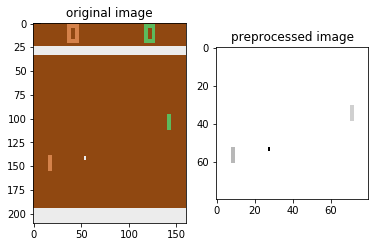

In [77]:
# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
print(frame.shape)
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()

In [78]:
# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

## Rollout

In [91]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(this is the same as policy_loss except the negative sign)

### REINFORCE
you have two choices (usually it's useful to divide by the time since we've normalized our rewards and the time of each trajectory is fixed)

1. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\log(\pi_{\theta'}(a_t|s_t))$
2. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}$ where $\theta'=\theta$ and make sure that the no_grad is enabled when performing the division

In [101]:
policy=pong_utils.Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

def states2prob(policy, states):
    """
    states: list[steps] x tensor[envs, frames, widths, heights]
    """
    states = torch.stack(states) # tensor[steps, envs, frames, widths, heights]
    policy_input = states.view(-1, *states.shape[-3:]) # tensor[steps * envs, frames, widths, heights]
    out = policy(policy_input) # tensor[steps * envs, 1]
    return out.view(states.shape[:-3]) # tensor[steps, envs]

def transform_rewards(rewards, discount):
    """ Take rewards collected from env and: 
    1. apply discount
    2. turn into cumulative rewards
    3. normalize across all parallel envs

    rewards: list[steps] x ndarray[envs,]
    discount: int
    """
    discounts = discount ** np.arange(len(rewards))
    rewards = np.asarray(rewards) * discounts[:, np.newaxis] # ndarray[steps, envs]

    rewards = rewards[::-1].cumsum(axis=0)[::-1] # count backwards, 1st for cumsum to work, then for reordering

    rewards_mean = np.mean(rewards, axis=1, keepdims=True) # for each timestep, normalize across the parallel envs
    rewards_std = np.std(rewards, axis=1, keepdims=True)
    rewards = (rewards - rewards_mean) / (rewards_std + 1e-10)
    return rewards

def surrogate(policy, old_probs, states, actions, rewards, discount=0.995, beta=0.01):
    rewards = transform_rewards(rewards, discount)

    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards, dtype=torch.float, device=device)

    new_probs = states2prob(policy, states) # tensor[steps, envs]
    new_probs = torch.where(actions==pong_utils.RIGHT, new_probs, 1-new_probs)

    entropy = -(new_probs * torch.log(old_probs + 1e-10) \
                + (1-new_probs) * torch.log(1 - old_probs + 1e-10))

    out = torch.mean(rewards * torch.log(new_probs + 1e-10) + beta * entropy)
    return out

loss_surrogate= surrogate(policy, prob, state, action, reward)
print(loss_surrogate)

tensor(0.0079, device='cuda:0', grad_fn=<MeanBackward0>)


In [103]:
from parallelEnv import parallelEnv
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
# episode = 500
# episode = 800
episode = 2000

# widget bar to display progress
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
beta = .01
# tmax = 320
tmax = 100

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)

    # this is the SOLUTION!
    # use your own surrogate function
    L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    
    # L = -pong_utils.surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L
        
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

Episode: 20, score: -3.250000
[-4. -5. -4. -1. -4. -3.  0. -5.]
Episode: 40, score: -4.250000
[-5. -5. -5. -5. -3. -5. -2. -4.]
Episode: 60, score: -3.000000
[-1. -3. -2. -4. -3. -4. -3. -4.]
Episode: 80, score: -4.125000
[-3. -4. -4. -5. -3. -4. -5. -5.]
Episode: 100, score: -3.625000
[-4. -3. -3. -3. -2. -4. -5. -5.]
Episode: 120, score: -3.500000
[-4. -4. -3. -3. -5. -3. -3. -3.]
Episode: 140, score: -3.875000
[-5. -5. -4. -4. -4. -2. -4. -3.]
Episode: 160, score: -3.375000
[-4. -4. -4. -5. -3. -4.  0. -3.]
Episode: 180, score: -3.500000
[-3. -2. -4. -4. -4. -4. -4. -3.]
Episode: 200, score: -3.500000
[-3. -4. -4. -2. -3. -5. -4. -3.]
Episode: 220, score: -3.125000
[-5. -4. -2. -2. -3. -2. -4. -3.]
Episode: 240, score: -4.000000
[-4. -4. -5. -4. -3. -4. -5. -3.]
Episode: 260, score: -4.000000
[-4. -3. -5. -3. -5. -5. -4. -3.]
Episode: 280, score: -2.625000
[-3. -1. -4. -1. -3. -3. -3. -3.]
Episode: 300, score: -3.750000
[-3. -4. -3. -3. -3. -4. -5. -5.]
Episode: 320, score: -3.50000